#**SIT 720 - Machine Learning**

Lecturer: Chandan Karmakar | karmakar@deakin.edu.au

School of Information Technology,
<br/>Deakin University, VIC 3125, Australia.

#**Assessment Task 2 (30 marks)**

##**Submission Instruction**
1.  Student should insert Python code or text responses into the cell followed by the question.

2.  For answers regarding discussion or explanation, **maximum five sentences are suggested**.

3.  Rename this notebook file appending your student ID. For example, for student ID 1234, the submitted file name should be A2_1234.ipynb.

4.  Insert your student ID and name in the following cell.

In [1]:
# Student ID: 218191552

# Student name: Pradeep Thapa

## Part 1: Clustering *(15 marks)*

Let's assume you want to design an environment to predict a class/category from a dataset based on specific features of that class. However, all the features are not strong enough or in other words features not that much variance/uniqueness across the classes. So, you have to design a clustering model by answering the following questions:

1. Download the attached clustering.csv file. Read the file and separate the class and feature matrix. __(2 marks)__

In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from kneed import KneeLocator # used for finding the optimal value of k
from sklearn import metrics
from pyclustering.utils.metric import distance_metric, type_metric
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from pyclustering.cluster.kmeans import kmeans
# seed for reproducibility
np.random.seed(3894)

# read file
df = pd.read_csv('clustering.csv')

# features
features = df.iloc[:, :7]

# class
target = df['Class']

# print
print('Dataframe:\n', df.head())
print('#########################################')
print('Features Matrix:\n',features)
print('#########################################')
print('Class Matrix:\n', target)

Dataframe:
    height  length   width    std    min    max  kurtosis  Class
0   15.26   14.84  0.8710  5.763  3.312  2.221     5.220      0
1   14.88   14.57  0.8811  5.554  3.333  1.018     4.956      0
2   14.29   14.09  0.9050  5.291  3.337  2.699     4.825      0
3   13.84   13.94  0.8955  5.324  3.379  2.259     4.805      0
4   16.14   14.99  0.9034  5.658  3.562  1.355     5.175      0
#########################################
Features Matrix:
      height  length   width    std    min    max  kurtosis
0     15.26   14.84  0.8710  5.763  3.312  2.221     5.220
1     14.88   14.57  0.8811  5.554  3.333  1.018     4.956
2     14.29   14.09  0.9050  5.291  3.337  2.699     4.825
3     13.84   13.94  0.8955  5.324  3.379  2.259     4.805
4     16.14   14.99  0.9034  5.658  3.562  1.355     5.175
..      ...     ...     ...    ...    ...    ...       ...
205   12.19   13.20  0.8783  5.137  2.981  3.631     4.870
206   11.23   12.88  0.8511  5.140  2.795  4.325     5.003
207   13.20  

2. Determine the number of clusters from the dataset. Is this same as the actual number of classes in the dataset? __(1 marks)__

<!-- Choose the best three features using different selection criteria (ANOVA, Chi-squared) based on the purity score for the k-mean cluster (Euclidean distance matrix). Which one is good and why? __(5 marks)__ -->

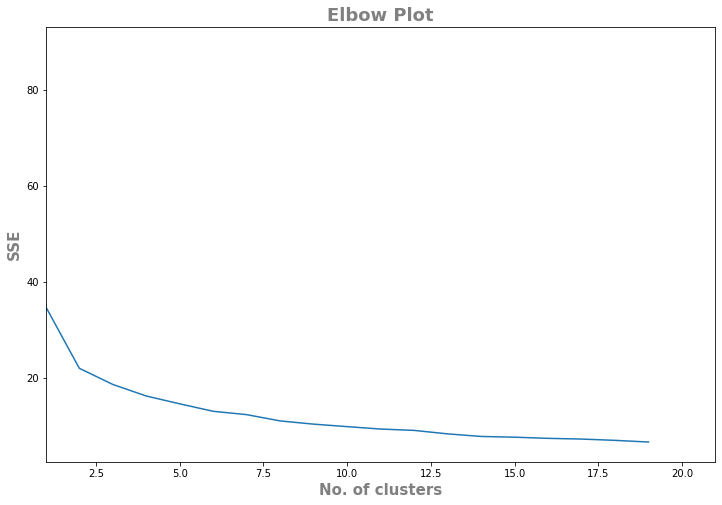

Optimal value of k is 3.
There are 3 unique classes so the number of clusters from the dataset is same number as well.  


In [3]:
# check unique class
unique = df['Class'].unique()

# get column names for features
cols = [i for i in features.columns]

# feature scaling
'''
Important for distance based algorithms.
Minmax scales the values for each numerical feature in the dataset
so that the features have range between 0 and 1.
'''
def scale(features):
    '''
    :param features: features dataframe
    :return: features: scaled features dataframe
    '''
    scaler = MinMaxScaler()
    features = scaler.fit_transform(features)
    return features

# scale features
scaled_features = scale(features)

# convert back to dataframe
features = pd.DataFrame(scaled_features, columns=cols)

# store sum of squared distance
sse = []

# find the optimal K value
for i in range(1, 21):
    # initiate the kmeans
    _kmeans = KMeans(n_clusters=i, init='random', n_init=10, max_iter=200, random_state=100)
    _kmeans.fit(features)
    sse.append(_kmeans.inertia_)

# plot the elbow graph
plt.figure(figsize=(12,8))
plt.title('Elbow Plot', color='gray', fontsize=18, fontweight='bold')
plt.plot(sse)
plt.xlabel('No. of clusters', color='gray', fontsize=15, fontweight='bold')
plt.ylabel('SSE', color='gray', fontsize=15, fontweight='bold')
plt.xlim([1,21])
plt.show()

# find optimal value of k
k = KneeLocator(range(1,21), sse, curve='convex', direction='decreasing')
print(f'Optimal value of k is {k.elbow}.')

print(f'There are {len(unique)} unique classes so the number of clusters from the dataset is same number as well.  ')

3. Perform K-Means clustering on the complete dataset and report purity score. __(2 marks)__ 

In [4]:
# perform 3-Means
_kmeans = KMeans(n_clusters=3, init='random', n_init=10, max_iter=200, random_state=100)
_kmeans.fit(features)
cluster = _kmeans.labels_

# purity evaluation
def purity_score(target, cluster):
    # compute confusion matrix
    confusion_matrix = metrics.cluster.contingency_matrix(target, cluster)
    # return purity
    return np.sum(np.amax(confusion_matrix, axis=0)) / np.sum(confusion_matrix)

print(f'Purity score is {purity_score(target, cluster):.3f}') # 3-decimal point

Purity score is 0.890


4. There are several distance metrics for  K-Means such as euclidean, squared euclidean, Manhattan, Chebyshev, Minkowski. [ __Hints:__ See the pyclustering library for python.]
    - Your job is to compare the purity score of k-means clustering for different distance metrics. __(5 marks)__ 
    - Select the best distance metric and explain why this distance metric is best for the given dataset. __(2 marks)__ 

In [5]:
# Prepare initial centers using K-Means++ method.
initial_centers = kmeans_plusplus_initializer(features, 3).initialize()

# create metric that will be used for clustering
manhattan_metric = distance_metric(type_metric.MANHATTAN)

# create instance of K-Means using specific distance metric:
kmeans_instance = kmeans(features, initial_centers, metric=manhattan_metric)

# run cluster analysis and obtain results
kmeans_instance.process()
clusters = kmeans_instance.get_clusters()

# initialize to store cluster labels
cluster_label = np.zeros(len(features))

# for cluster 0 replace with 0
for cluster in clusters[0]:
    cluster_label[cluster] = 0

# for cluster 1 replace with 1
for cluster in clusters[1]:
    cluster_label[cluster] = 1

# for cluster 2 replace with 2
for cluster in clusters[2]:
    cluster_label[cluster] = 2

# calculate purity score
manhattan_purity = purity_score(target, cluster_label)
print(f'The manhattan distance based Kmeans purity is {manhattan_purity:.3f}')

The manhattan distance based Kmeans purity is 0.886


In [6]:
# create metric that will be used for clustering
euclidean_sqr_metric = distance_metric(type_metric.EUCLIDEAN_SQUARE)

# create instance of K-Means using specific distance metric:
kmeans_instance = kmeans(features, initial_centers, metric=euclidean_sqr_metric)

# run cluster analysis and obtain results
kmeans_instance.process()
clusters = kmeans_instance.get_clusters()

# initialize to store cluster labels
cluster_label = np.zeros(len(features))

# for cluster 0 replace with 0
for cluster in clusters[0]:
    cluster_label[cluster] = 0

# for cluster 1 replace with 1
for cluster in clusters[1]:
    cluster_label[cluster] = 1

# for cluster 2 replace with 2
for cluster in clusters[2]:
    cluster_label[cluster] = 2

# calculate purity score
euclidean_sqr_purity = purity_score(target, cluster_label)
print(f'The Euclidean Square distance based Kmeans purity is {euclidean_sqr_purity:.3f}')

The Euclidean Square distance based Kmeans purity is 0.895


In [7]:
# create metric that will be used for clustering
chebyshev_metric = distance_metric(type_metric.CHEBYSHEV)

# create instance of K-Means using specific distance metric:
kmeans_instance = kmeans(features, initial_centers, metric=chebyshev_metric)

# run cluster analysis and obtain results
kmeans_instance.process()
clusters = kmeans_instance.get_clusters()

# initialize to store cluster labels
cluster_label = np.zeros(len(features))

# for cluster 0 replace with 0
for cluster in clusters[0]:
    cluster_label[cluster] = 0

# for cluster 1 replace with 1
for cluster in clusters[1]:
    cluster_label[cluster] = 1

# for cluster 2 replace with 2
for cluster in clusters[2]:
    cluster_label[cluster] = 2

# calculate purity score
chebyshev_purity = purity_score(target, cluster_label)
print(f'The Chbyshev distance based Kmeans purity is {chebyshev_purity:.3f}')

The Chbyshev distance based Kmeans purity is 0.919


In [8]:
# create metric that will be used for clustering
minkowski_metric = distance_metric(type_metric.MINKOWSKI, degree=2)

# create instance of K-Means using specific distance metric:
kmeans_instance = kmeans(features, initial_centers, metric=minkowski_metric)

# run cluster analysis and obtain results
kmeans_instance.process()
clusters = kmeans_instance.get_clusters()

# initialize to store cluster labels
cluster_label = np.zeros(len(features))

# for cluster 0 replace with 0
for cluster in clusters[0]:
    cluster_label[cluster] = 0

# for cluster 1 replace with 1
for cluster in clusters[1]:
    cluster_label[cluster] = 1

# for cluster 2 replace with 2
for cluster in clusters[2]:
    cluster_label[cluster] = 2

# calculate purity score
minkowski_purity = purity_score(target, cluster_label)
print(f'The Minkowski distance based Kmeans purity is {minkowski_purity:.3f}')

The Minkowski distance based Kmeans purity is 0.890


There are several distance metrics to measure the similarity or regularity among the data items.
such distance metrics play vital role to identify in what manner the data are inter-related and
how various data similar or dissimilar with each other. The goal of using distance metric is to
get an appropriate distance/similarity based on the specific problem.
* Euclidean distance computes the root of square difference between co-ordinates of pair of objects.
* The Euclidean Squared distance metric uses the same equation as the Euclidean distance metric, but does not take the square root.
* Manhattan distance computes the absolute differences between coordinates of pair of objects
* Chebychev Distance is also known as maximum value distance and is computed as the absolute magnitude of the differences between coordinate of a pair of objects.
* Minkowski Distance is the generalized form of Euclidean and Manhattan Distance.

Purity Result:
* Euclidean --> 88.6
* Squared Eucliedean --> 89.5
* Manhattan --> 88.1
* Chbyshev --> 91.9
* Minkowski --> 89.0

As we can see that the Manhattan based Kmeans clustering had lowest purity. Similarly, Chbyshev distanced based Kmeans had highest purity score. Euclidean and Minkowski had a same score because Minkowski degee (p) is 2 which is same as Euclidean if we round the Euclidean distance. The centroids are randomly initialized which causes change in purity.

<b>Euclidean distance</b> is the best metric for the given dataset because of the following reasons:
<li>The dataset have features which are float and integer data types.
<li>It calculates the distance between two real valued vectors.
<li>Also this dataset has been normalised prior to calculating distance which converts all features to same scale.
<li>Data points with high values of features are clustered together and lower values of features are clustered together.


5. Use selection criteria (ANOVA, Chi-squared) to select best three features and use them for K-Means clustering. Based on the purity score which feature set are you going to recommend and why? __(3 marks)__

In [9]:
# Kmeans and purity
def kmeans_(features, target):
    # perform 3-Means
    kmeans = KMeans(n_clusters=3, init='random', n_init=10, max_iter=200, random_state=100)
    kmeans.fit(features)
    cluster = kmeans.labels_

    # purity evaluation
    def purity_score(target, cluster):
        # compute confusion matrix
        confusion_matrix = metrics.cluster.contingency_matrix(target, cluster)
        # return purity
        return np.sum(np.amax(confusion_matrix, axis=0)) / np.sum(confusion_matrix)

    print(f'Purity score is {purity_score(target, cluster):.3f}')

# ANOVA
anova_selector = SelectKBest(f_classif, k=3)
# Apply the SelectKBest object to the features and target
top_3_features = anova_selector.fit_transform(features, target)
print(top_3_features[0:1, :]) # check to see where values match to findout the column names
print('The top 3 features using ANOVA are: height, length and min.')
print('Kmeans and Purity Score using ANOVA:')
kmeans_(top_3_features, target)

print('#########################################')

# chi2
chi2_selector = SelectKBest(chi2, k=3)
top3_chi2 = chi2_selector.fit_transform(features, target)
print(top3_chi2[0:1, :]) # check to see where values match to findout the column names
print('The top 3 features using Chi-square are: height, length and min.')
print('Kmeans and Purity Score using Chi2:')
kmeans_(top3_chi2, target)
print('#########################################')

print('Although both ANOVA and chi2 have same purity and exactly same top 3 features, '
      'I would recommend ANOVA because the features in the dataset are quantitative. Chi-Sqaure is based on the proportions of the two or more groups. Simply it deals with categorical variables (Nominal Scale).',
      'However, our dataset has numerical values which makes ANOVA a preferred choice.')

[[0.44098206 0.50206612 0.48610121]]
The top 3 features using ANOVA are: height, length and min.
Kmeans and Purity Score using ANOVA:
Purity score is 0.848
#########################################
[[0.44098206 0.50206612 0.48610121]]
The top 3 features using Chi-square are: height, length and min.
Kmeans and Purity Score using Chi2:
Purity score is 0.848
#########################################
Although both ANOVA and chi2 have same purity and exactly same top 3 features, I would recommend ANOVA because the features in the dataset are quantitative. Chi-Sqaure is based on the proportions of the two or more groups. Simply it deals with categorical variables (Nominal Scale). However, our dataset has numerical values which makes ANOVA a preferred choice.


# Part-2 (Dimensionality Reduction using PCA/SVD) *(15 marks)*

1. For the dataset (clustering.csv), perform PCA.
    - plot the captured variance with respect to increasing latent dimensionality. __(2.5 marks)__
  
  What is the minimum dimension that captures:
    - at least 89% variance? __(1.5 marks)__
    - at least 99% variance? __(1 marks)__

[7.89033617e-01 1.29094899e-01 6.86669794e-02 9.43131103e-03
 2.73880652e-03 8.93295102e-04 1.41091525e-04]


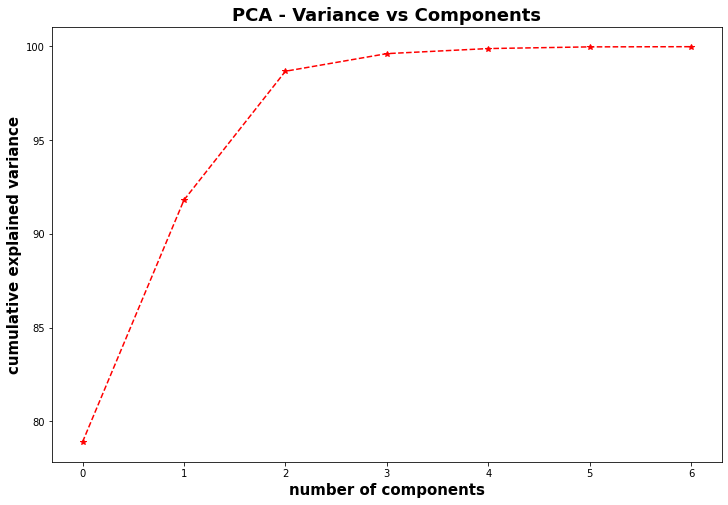

The minimum dimension that captures at least 89% variance is 2 dimensions.
The minimum dimension that captures at least 99% variance is 4 dimensions.


In [10]:
# perform PCA
pca = PCA(n_components=7)
pca.fit(features, target)
print(pca.explained_variance_ratio_)

# plot no of components vs cumulative explained variance
plt.figure(figsize=(12,8))
plt.title('PCA - Variance vs Components', fontsize=18, fontweight='bold')
plt.plot(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100), marker='*', linestyle='--', color='r')
plt.xlabel('number of components', fontsize=15, fontweight='bold')
plt.ylabel('cumulative explained variance', fontsize=15, fontweight='bold')
plt.show()

# store variance and number of components
all_variances = []
variance_89 = [] # at least 89% variance
variance_99 = [] # at least 99% variance

# get variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
for component, variance in enumerate(cumulative_variance.tolist()):
    all_variances.append((component+1, variance))
    if variance >= 0.89:
        variance_89.append((component+1, variance)) # +1 because first component is 0
    if variance >=0.99:
        variance_99.append((component+1, variance))
    else:
        continue

'''
Currently appending in order so not required.
# sort stored variances
variance_89.sort(key=lambda x:x[1], reverse=True)
variance_99.sort(key=lambda x:x[1], reverse=True)'''

# get number of min components for >89% variance
print(f'The minimum dimension that captures at least 89% variance is {variance_89[0][0]} dimensions.')
# get number of min components for >99% variance
print(f'The minimum dimension that captures at least 99% variance is {variance_99[0][0]} dimensions.')

2. Determine the purity of clusters formed by the number of principal components which captured 89% and 99% variances respectively. Plot a line graph of the purity scores against the captured variances. Discuss your findings. __(7 marks)__

At least 89% Variance
PCA dataframe for 2 components:
     component_1  component_2
0       0.075029     0.129691
1      -0.024301     0.364120
2      -0.149375     0.456497
3      -0.180881     0.440557
4       0.250589     0.441297
..           ...          ...
205    -0.533393     0.201720
206    -0.703762    -0.059483
207    -0.336222    -0.085931
208    -0.606683    -0.014199
209    -0.498803    -0.054545

[210 rows x 2 columns]
For cluster 1: Purity is 0.333
For cluster 2: Purity is 0.657
For cluster 3: Purity is 0.886
For cluster 4: Purity is 0.876
For cluster 5: Purity is 0.890
For cluster 6: Purity is 0.890
For cluster 7: Purity is 0.905
For cluster 8: Purity is 0.924
For cluster 9: Purity is 0.914
For cluster 10: Purity is 0.919
For cluster 11: Purity is 0.929
For cluster 12: Purity is 0.929
For cluster 13: Purity is 0.919
For cluster 14: Purity is 0.914
For cluster 15: Purity is 0.895
For cluster 16: Purity is 0.910
For cluster 17: Purity is 0.914
For cluster 18: Purity is 0

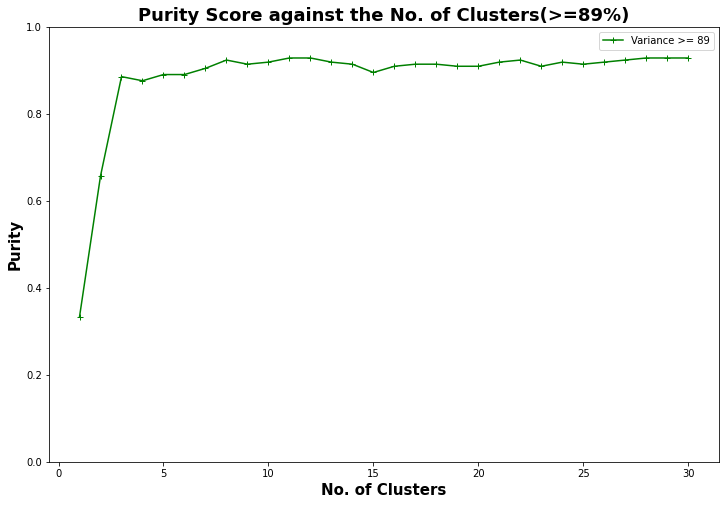

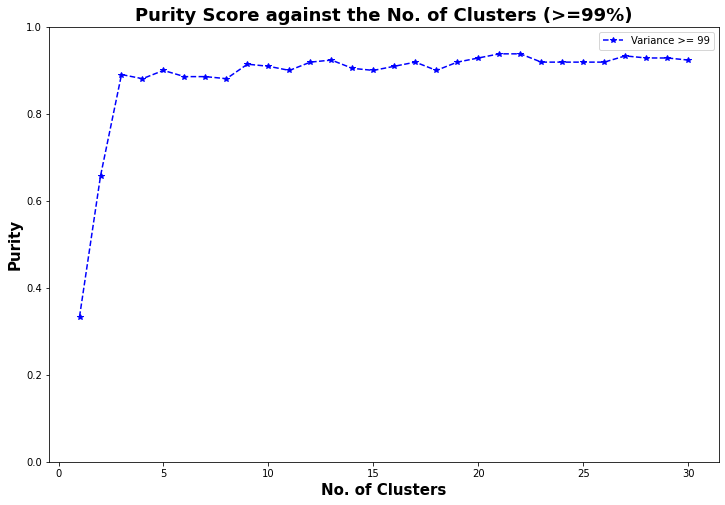

In [11]:
'''
Determine the purity of clusters formed by the number of principal components which captured 89% and 99% variances respectively.

Assumptions:
This number of components which captured 89% and 99% variances are the minimum dimension that captures at least that percentage of variance.
Find the optimal value of K between 1-30
'''
# kmeans and purity function
def kmeans_purity(features, target, n_component):
    # perform pca
    pca  = PCA(n_components=n_component)
    pca = pca.fit_transform(features,target)
    # name columns
    cols = ['component_'+ str(i) for i in range(1, n_component+1)]
    pca_data = pd.DataFrame(pca, columns=cols) # create dataframe from components
    print(f'PCA dataframe for {n_component} components:\n{pca_data}')

    # store purity scores
    purity_scores = []

    # perform kmeans with cluster between 1 to 30
    for i in range(1,31):
        kmeans = KMeans(n_clusters=i, init='random', n_init=10, max_iter=300, random_state=100)
        kmeans.fit(pca_data)
        cluster = kmeans.labels_
        # purity evaluation
        def purity_score(target, cluster):
            # compute confusion matrix
            confusion_matrix = metrics.cluster.contingency_matrix(target, cluster)
            # return purity
            return np.sum(np.amax(confusion_matrix, axis=0)) / np.sum(confusion_matrix)
        purity = purity_score(target, cluster)
        purity_scores.append((i, purity))
    return purity_scores

print('At least 89% Variance')


purity_scores_89 = kmeans_purity(features, target, variance_89[0][0])

# print component and their purity score
for n_cluster, purity in purity_scores_89:
    print(f'For cluster {n_cluster}: Purity is {purity:.3f}')

print('##################################')
print('At least 99% Variance')
purity_scores_99 = kmeans_purity(features, target, variance_99[0][0])

# print component and their purity score
for n_cluster, purity in purity_scores_99:
    print(f'For cluster {n_cluster}: Purity is {purity:.3f}')


# plot graph for variance of at least 89%
plt.figure(figsize=(12,8))
plt.title('Purity Score against the No. of Clusters(>=89%)', fontsize=18, fontweight='bold')
plt.xlabel('No. of Clusters', fontsize=15, fontweight='bold')
plt.ylabel('Purity', fontsize=15, fontweight='bold')
plt.plot([i[0] for i in purity_scores_89], [i[1] for i in purity_scores_89], marker='+', color='g', label='Variance >= 89')
plt.ylim([0,1])
plt.legend()
plt.show()


# plot graph for variance of at least 99%
plt.figure(figsize=(12,8))
plt.title('Purity Score against the No. of Clusters (>=99%)', fontsize=18, fontweight='bold')
plt.xlabel('No. of Clusters', fontsize=15, fontweight='bold')
plt.ylabel('Purity', fontsize=15, fontweight='bold')
plt.plot([i[0] for i in purity_scores_99], [i[1] for i in purity_scores_99], marker='*', color='b', label='Variance >= 99', linestyle='--')
plt.ylim([0,1])
plt.legend()
plt.show()

**Observation**<br>
 we can see that K=3 seems to be optimal purity value for both 89% and 99% variance so we can use k=3 as optimal to use for k-means clustering.
 There is significant increase in purity until 3 clusters and then it starts to fall down or stay stationary and does not reflect significant increase in purity score.

(Variance, Purity_score) --> [(0.7890336169668163, 0.861904761904762), (0.9181285163980158, 0.8857142857142857), (0.9867954958234737, 0.8857142857142857), (0.9962268068537803, 0.8904761904761904), (0.998965613372981, 0.8904761904761904), (0.9998589084748079, 0.8904761904761904), (0.9999999999999999, 0.8904761904761904)]

Purity score for 89% variance is 0.886
Purity score for 99% variance is 0.890


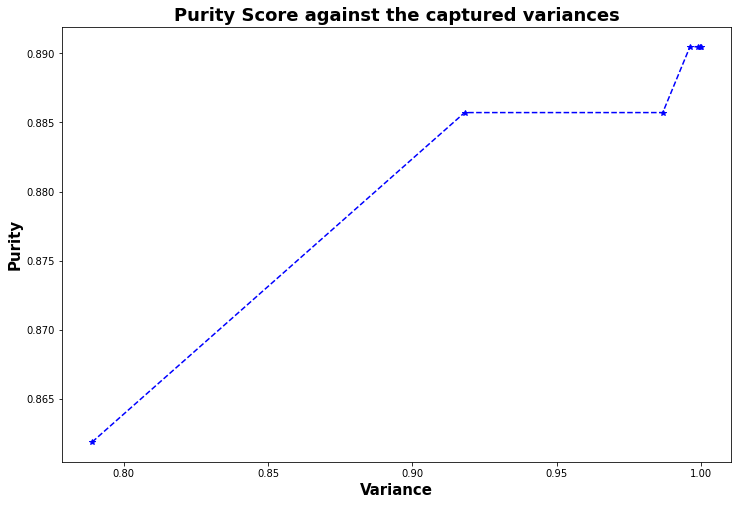

In [12]:
# Plot a line graph of the purity scores against the captured variances.
'''
Assumption
- captured variances refer to all the captured variances (not just 89% and 99%)
- we have seen k=3 as optimal value of Kmeans clustering.
'''
# kmeans and purity function
def pca_and_kmeans(n_component):
    # perform pca
    pca  = PCA(n_components=n_component)
    pca = pca.fit_transform(features,target)
    # name columns
    cols = ['component_'+ str(i) for i in range(1, n_component+1)]
    pca_data = pd.DataFrame(pca, columns=cols) # create dataframe from components
    #print(f'PCA dataframe for {n_component} components:\n{pca_data}')

    # perform kmeans with cluster 3
    kmeans = KMeans(n_clusters=3, init='random', n_init=10, max_iter=300, random_state=100)
    kmeans.fit(pca_data)
    cluster = kmeans.labels_
    # purity evaluation
    confusion_matrix = metrics.cluster.contingency_matrix(target, cluster)
    # return purity
    purity = np.sum(np.amax(confusion_matrix, axis=0)) / np.sum(confusion_matrix)
    return purity

# store purity for every variance
purity_var_score = []

# all variances
'''
:var all_variances has all the variances from previous step
'''
for variance in all_variances:
    purity = pca_and_kmeans(variance[0])
    purity_var_score.append((variance[1], purity))
    
# print purity scores for each variance
print(f'(Variance, Purity_score) --> {purity_var_score}')
print()

# print purity scores for 89% and 99% variance
print(f'Purity score for 89% variance is {purity_var_score[1][1]:.3f}')
print(f'Purity score for 99% variance is {purity_var_score[3][1]:.3f}')

# plot graph for purity against variance
plt.figure(figsize=(12,8))
plt.title('Purity Score against the captured variances', fontsize=18, fontweight='bold')
plt.xlabel('Variance', fontsize=15, fontweight='bold')
plt.ylabel('Purity', fontsize=15, fontweight='bold')
plt.plot([i[0] for i in purity_var_score], [i[1] for i in purity_var_score], marker='*', color='b', linestyle='--')
plt.show()

**Observation:**<br>
As the first principal component accounts for as much of the variability in the data as possible, and each succeeding component accounts for as much of the remaining variability as possible, similarly Purity is increased as the variance increased. However, from the above graph we can see that there were variances where it was constant for few variances and then it started increase again and become stationary again.

We can also conclude that the lower variance has lower purity score and the higher variance has higher purity score which can be said to have linear relationship or highly correlated.

If we just consider variances of 89% and 99%, we can say that there is a difference in purity score as 99% variance has larger purity score compared to 89%. The purity score for 89% variance with 2 components is 88.6% and for 99% variance with 4 components, the purity score is 0.89.

3. Let's assume you have two datasets one is linear and another is curved structural data.
    - Can we apply PCA on these datasets? Justify your answer. __(3 marks)__ 

We can apply PCA only on linear dataset as PCA is simple linear transformation on the input space to directions of maximum variations. In addition, it creates a linear map and for this reason it is limited to learning linear relationships between features.'
      For curved structural data, we can not apply PCA because data is not linear. Techniques'
      such as AutoEncoder can be applied for complex and non linear data.
Some recommended approches for curved structural data:
<li>Kernel Principal Component Analysis
<li>Isometric feature mapping (ISOMAP)
<li>Local linear embedding
<li>Local Multi-Dimensional Scaling (MDS)